In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

In [6]:
# Konfigurasi Dataset
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
IMG_SIZE = (160, 160)
EPOCHS = 20
SEED = 123

In [7]:
#Load dataset  & split
(ds_all, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train', 'train[90%:100%]'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True
)
full_ds = ds_all


In [8]:
# compute sizes
num_examples = ds_info.splits['train'].num_examples
print("Total images:", num_examples)


full_ds = full_ds.shuffle(1000, seed=SEED)
train_size = int(0.8 * num_examples)
val_size   = int(0.1 * num_examples)
test_size  = num_examples - train_size - val_size

ds_train = full_ds.take(train_size)
ds_remaining = full_ds.skip(train_size)
ds_val = ds_remaining.take(val_size)
ds_test = ds_remaining.skip(val_size)

print("Split sizes:", train_size, val_size, test_size)


Total images: 23262
Split sizes: 18609 2326 2327


In [9]:
# 3) Preprocessing functions
def preprocess(image, label):
    # Resize and normalize to [0,1]
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment(image, label):
    # simple augmentation: flip, rotate, brightness
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # random crop/rescale not used to keep stable shape
    return image, label


In [10]:
#4) Prepare tf.data pipelines
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000, seed=SEED) \
                   .batch(BATCH_SIZE) \
                   .prefetch(AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = max(1, val_size // BATCH_SIZE)


In [11]:
# 5) Build Sequential CNN model (Conv2D + Pooling)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    # Block 4 (optional deeper)
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,665,473 (13.98 MB)

 Trainable params: 3,665,473 (13.98 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
#6) Callbacks
checkpoint_path = "best_model_ckpt.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
]

In [13]:
# 7) Train
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=ds_val,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/20
1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5988 - loss: 0.6561

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 63s 44ms/step - accuracy: 0.5989 - loss: 0.6561 - val_accuracy: 0.7147 - val_loss: 0.5502 - learning_rate: 1.0000e-04
Epoch 2/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 50:09 3s/step - accuracy: 0.0000e+00 - loss: 0.9240

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 3s 599us/step - accuracy: 0.0000e+00 - loss: 0.9240 - val_accuracy: 0.7060 - val_loss: 0.5551 - learning_rate: 1.0000e-04
Epoch 3/20
1161/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7077 - loss: 0.5621

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.7077 - loss: 0.5620 - val_accuracy: 0.7379 - val_loss: 0.5193 - learning_rate: 1.0000e-04
Epoch 4/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 1.0000 - loss: 0.2353 - val_accuracy: 0.7345 - val_loss: 0.5235 - learning_rate: 1.0000e-04
Epoch 5/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7429 - loss: 0.5258

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.7429 - loss: 0.5258 - val_accuracy: 0.7483 - val_loss: 0.4964 - learning_rate: 1.0000e-04
Epoch 6/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0000e+00 - loss: 0.8626

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.0000e+00 - loss: 0.8626 - val_accuracy: 0.7767 - val_loss: 0.4708 - learning_rate: 1.0000e-04
Epoch 7/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7694 - loss: 0.4806

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.7694 - loss: 0.4806 - val_accuracy: 0.8147 - val_loss: 0.4213 - learning_rate: 1.0000e-04
Epoch 8/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.0000e+00 - loss: 1.0102 - val_accuracy: 0.8125 - val_loss: 0.4253 - learning_rate: 1.0000e-04
Epoch 9/20
1161/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7893 - loss: 0.4463

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.7893 - loss: 0.4463 - val_accuracy: 0.8280 - val_loss: 0.3954 - learning_rate: 1.0000e-04
Epoch 10/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 1.0000 - loss: 0.1621 - val_accuracy: 0.8198 - val_loss: 0.4026 - learning_rate: 1.0000e-04
Epoch 11/20
1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8090 - loss: 0.4219

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8090 - loss: 0.4219 - val_accuracy: 0.8483 - val_loss: 0.3577 - learning_rate: 1.0000e-04
Epoch 12/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 1.0000 - loss: 0.1689 - val_accuracy: 0.8474 - val_loss: 0.3588 - learning_rate: 1.0000e-04
Epoch 13/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8199 - loss: 0.3986 - val_accuracy: 0.8315 - val_loss: 0.3717 - learning_rate: 1.0000e-04
Epoch 14/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.8328 - val_loss: 0.3726 - learning_rate: 1.0000e-04
Epoch 15/20
1162/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8401 - loss: 0.3701

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.8401 - loss: 0.3701 - val_accuracy: 0.8629 - val_loss: 0.3284 - learning_rate: 5.0000e-05
Epoch 16/20
   1/1163 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 1.0000 - loss: 0.0461

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 1.0000 - loss: 0.0461 - val_accuracy: 0.8638 - val_loss: 0.3286 - learning_rate: 5.0000e-05
Epoch 17/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8448 - loss: 0.3552

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8448 - loss: 0.3552 - val_accuracy: 0.8733 - val_loss: 0.3170 - learning_rate: 5.0000e-05
Epoch 18/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.0000e+00 - loss: 1.8672 - val_accuracy: 0.8716 - val_loss: 0.3173 - learning_rate: 5.0000e-05
Epoch 19/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.8520 - loss: 0.3421 - val_accuracy: 0.8698 - val_loss: 0.3133 - learning_rate: 5.0000e-05
Epoch 20/20
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 1.7154 - val_accuracy: 0.8728 - val_loss: 0.3148 - learning_rate: 5.0000e-05


In [14]:
#8) Evaluate on train & test sets
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

train_eval_ds = full_ds.take(train_size).map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)
train_loss, train_acc = model.evaluate(train_eval_ds, verbose=2)
print(f"Train accuracy: {train_acc:.4f}, Train loss: {train_loss:.4f}")


146/146 - 21s - 145ms/step - accuracy: 0.8457 - loss: 0.3508
Test accuracy: 0.8457, Test loss: 0.3508
1164/1164 - 23s - 20ms/step - accuracy: 0.8646 - loss: 0.3197
Train accuracy: 0.8646, Train loss: 0.3197


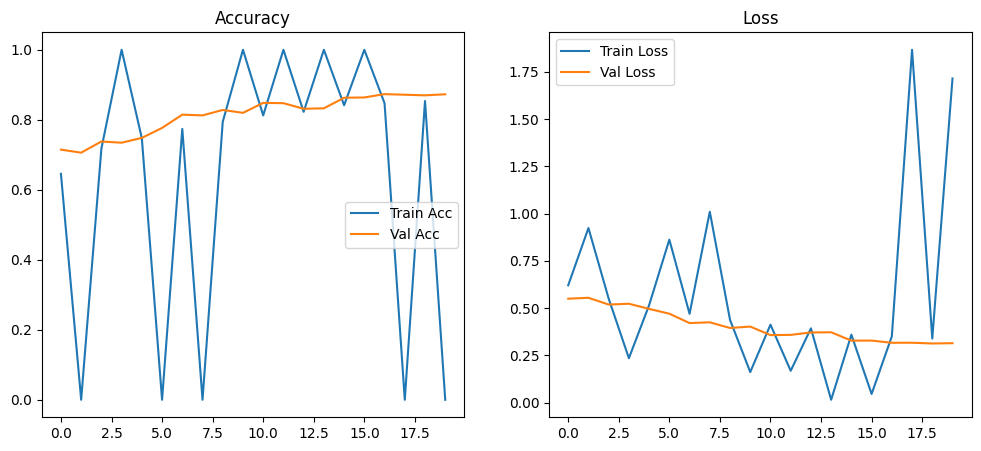

In [15]:
# 9) Plot accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


## **Menyimpan model ke format savemodel**

In [18]:
# 10) Save model: SavedModel
saved_model_path = "best_model.keras"
model.save(saved_model_path)

print("SavedModel saved to:", saved_model_path)

SavedModel saved to: best_model.keras


## **Menyimpan ke format TFLite**

In [20]:
# 11) Convert and save to TFLite
tflite_model_path = "model_cats_vs_dogs.tflite"
saved_model_path = "best_model.keras"

# Load the saved Keras model
loaded_model = tf.keras.models.load_model(saved_model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model saved to:", tflite_model_path)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpccvybpui'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135705913949840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135705913948880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135705913949264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813439504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813439696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813438352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813440464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813437776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813437392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813438544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135704813437008

## **Menyimpan ke format TFjs**

In [24]:
model.save("model_cats_vs_dogs.h5")


In [25]:
!tensorflowjs_converter \
    --input_format=keras \
    --output_format=tfjs_layers_model \
    model_cats_vs_dogs.h5 \
    tfjs_model_cats_vs_dogs


2025-09-12 08:11:42.138840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757664702.158412   23776 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757664702.164878   23776 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757664702.180663   23776 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757664702.180688   23776 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757664702.180692   23776 computation_placer.cc:177] computation placer alr